# 01. Data Exploration and Feature Engineering

## Project Overview

**Objective**: Detect fraudulent Medicare providers using claims and beneficiary data.

**Datasets**:
- `Train_Beneficiarydata.csv`: Patient demographics and chronic conditions
- `Train_Inpatientdata.csv`: Hospital admission claims
- `Train_Outpatientdata.csv`: Outpatient visit claims
- `Train_Labels.csv`: Provider-level fraud labels (Yes/No)

**Key Challenge**: Class imbalance (~10% fraud rate) and multi-table data requiring aggregation.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization Settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [3]:
DATA_DIR = '../data/'

# Load datasets
train_bene = pd.read_csv(DATA_DIR + 'Train_Beneficiarydata.csv')
train_inpatient = pd.read_csv(DATA_DIR + 'Train_Inpatientdata.csv')
train_outpatient = pd.read_csv(DATA_DIR + 'Train_Outpatientdata.csv')
train_labels = pd.read_csv(DATA_DIR + 'Train_Labels.csv')

print(f"Beneficiary Data Shape: {train_bene.shape}")
print(f"Inpatient Data Shape: {train_inpatient.shape}")
print(f"Outpatient Data Shape: {train_outpatient.shape}")
print(f"Labels Data Shape: {train_labels.shape}")

print("\nFirst few rows of Labels:")
train_labels.head()

Beneficiary Data Shape: (138556, 25)
Inpatient Data Shape: (40474, 30)
Outpatient Data Shape: (517737, 27)
Labels Data Shape: (5410, 2)

First few rows of Labels:


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


## 2. Understanding Data Relationships

### Key Identifiers

1. **BeneID (Beneficiary ID)**: 
   - Links patients to their claims
   - One beneficiary can have multiple claims (both inpatient and outpatient)
   - Found in: `Train_Beneficiarydata`, `Train_Inpatientdata`, `Train_Outpatientdata`

2. **Provider ID**:
   - Links claims to fraud labels
   - One provider can serve multiple beneficiaries and file multiple claims
   - Found in: `Train_Inpatientdata`, `Train_Outpatientdata`, `Train_Labels`

3. **ClaimID**:
   - Unique identifier for each claim
   - Found in: `Train_Inpatientdata`, `Train_Outpatientdata`

### Unit of Analysis: PROVIDER

**Why Provider-Level?**
- Fraud labels are assigned at the **Provider** level, not claim or patient level
- A fraudulent provider may file many claims, some legitimate and some fraudulent
- We must aggregate all claim-level and patient-level information to characterize each provider's behavior

**Data Flow**:
```
Beneficiary Data (BeneID) 
         ↓ (merge on BeneID)
Claims Data (BeneID, Provider, ClaimID)
         ↓ (aggregate by Provider)
Provider-Level Features (Provider)
         ↓ (merge on Provider)
Final Dataset with Labels (Provider, Features, PotentialFraud)
```

## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Variable Distribution

Fraud Distribution:
PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

Percentages:
PotentialFraud
No     90.64695
Yes     9.35305
Name: proportion, dtype: float64


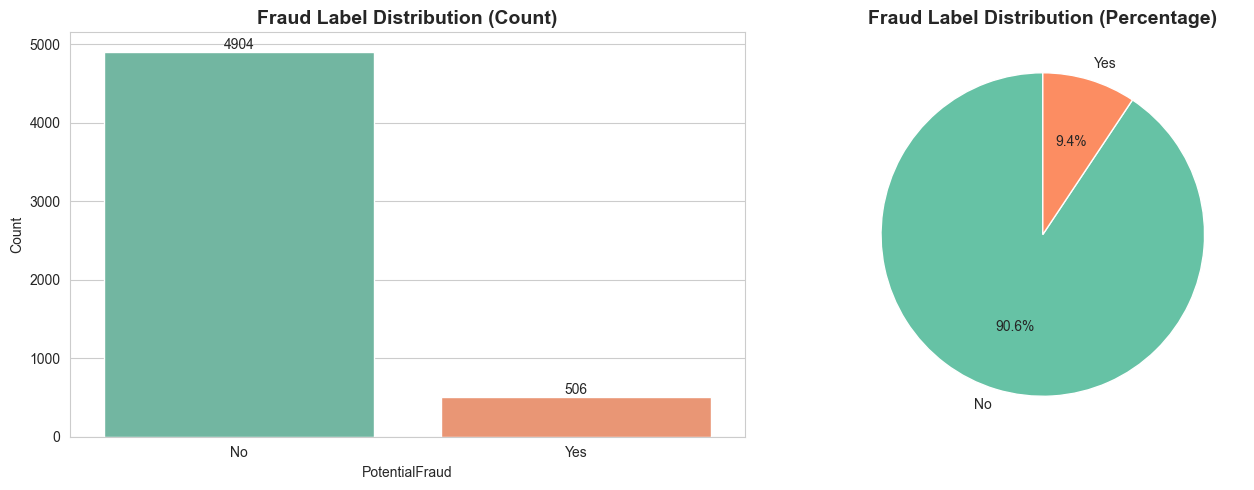


⚠️ CLASS IMBALANCE DETECTED: 9.35% fraud cases


In [4]:
# Class distribution
fraud_counts = train_labels['PotentialFraud'].value_counts()
fraud_pct = train_labels['PotentialFraud'].value_counts(normalize=True) * 100

print("Fraud Distribution:")
print(fraud_counts)
print("\nPercentages:")
print(fraud_pct)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train_labels, x='PotentialFraud', palette='Set2', ax=axes[0])
axes[0].set_title('Fraud Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

# Pie chart
axes[1].pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', 
            colors=['#66c2a5', '#fc8d62'], startangle=90)
axes[1].set_title('Fraud Label Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ CLASS IMBALANCE DETECTED: {fraud_pct['Yes']:.2f}% fraud cases")

### 3.2 Missing Value Analysis


Missing Values in Beneficiary Data
Column  Missing_Count  Missing_Percentage
   DOD         137135           98.974422


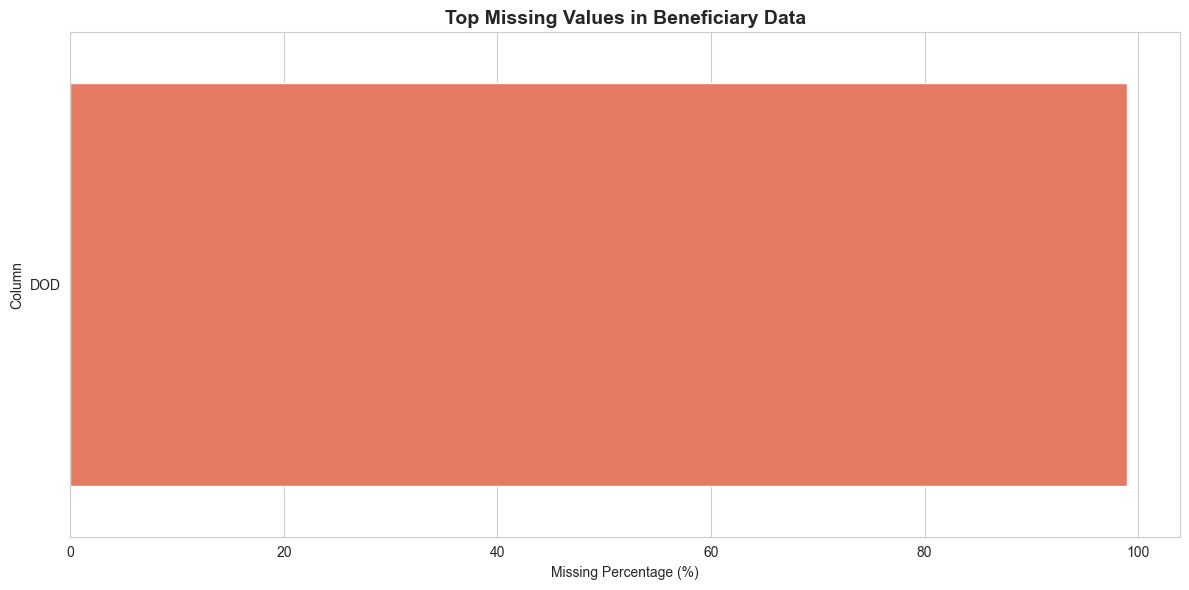


Missing Values in Inpatient Data
             Column  Missing_Count  Missing_Percentage
 ClmProcedureCode_6          40474          100.000000
 ClmProcedureCode_5          40465           99.977764
 ClmProcedureCode_4          40358           99.713396
 ClmProcedureCode_3          39509           97.615753
ClmDiagnosisCode_10          36547           90.297475
     OtherPhysician          35784           88.412314
 ClmProcedureCode_2          35020           86.524683
 ClmProcedureCode_1          17326           42.807728
 OperatingPhysician          16644           41.122696
 ClmDiagnosisCode_9          13497           33.347334
 ClmDiagnosisCode_8           9942           24.563918
 ClmDiagnosisCode_7           7258           17.932500
 ClmDiagnosisCode_6           4838           11.953353
 ClmDiagnosisCode_5           2894            7.150269
 ClmDiagnosisCode_4           1534            3.790087
  DeductibleAmtPaid            899            2.221179
 ClmDiagnosisCode_3            

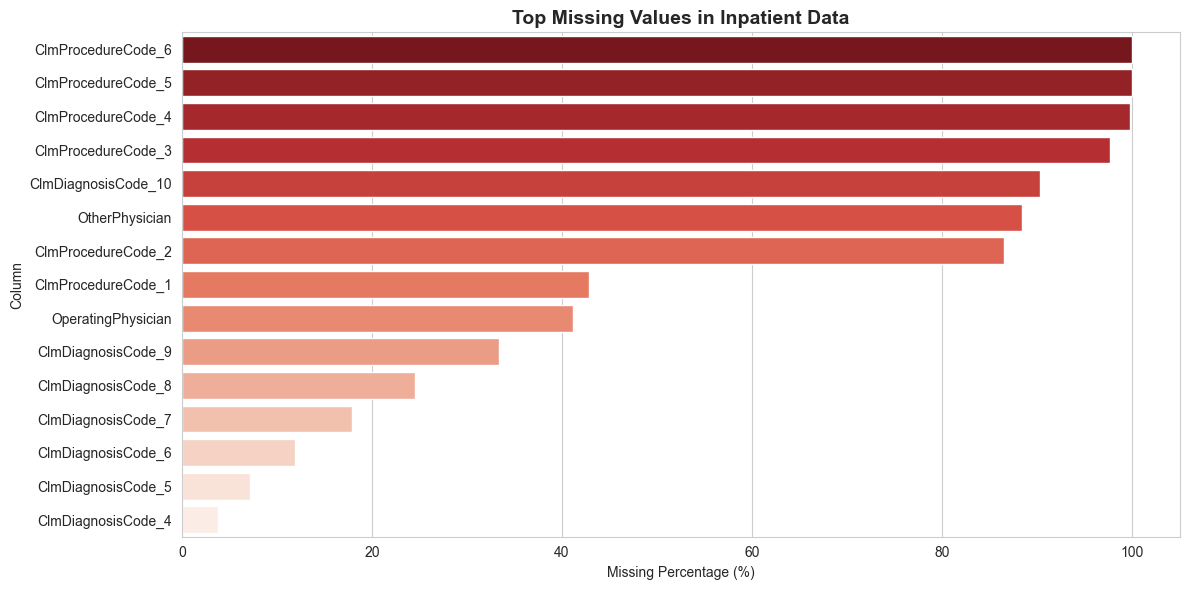


Missing Values in Outpatient Data
               Column  Missing_Count  Missing_Percentage
   ClmProcedureCode_6         517737          100.000000
   ClmProcedureCode_5         517737          100.000000
   ClmProcedureCode_4         517735           99.999614
   ClmProcedureCode_3         517733           99.999227
   ClmProcedureCode_2         517701           99.993047
   ClmProcedureCode_1         517575           99.968710
  ClmDiagnosisCode_10         516654           99.790820
   ClmDiagnosisCode_9         502899           97.134066
   ClmDiagnosisCode_8         494825           95.574587
   ClmDiagnosisCode_7         484776           93.633640
   ClmDiagnosisCode_6         468981           90.582864
   ClmDiagnosisCode_5         443393           85.640586
   OperatingPhysician         427120           82.497484
ClmAdmitDiagnosisCode         412312           79.637345
   ClmDiagnosisCode_4         392141           75.741351
       OtherPhysician         322691           62.327

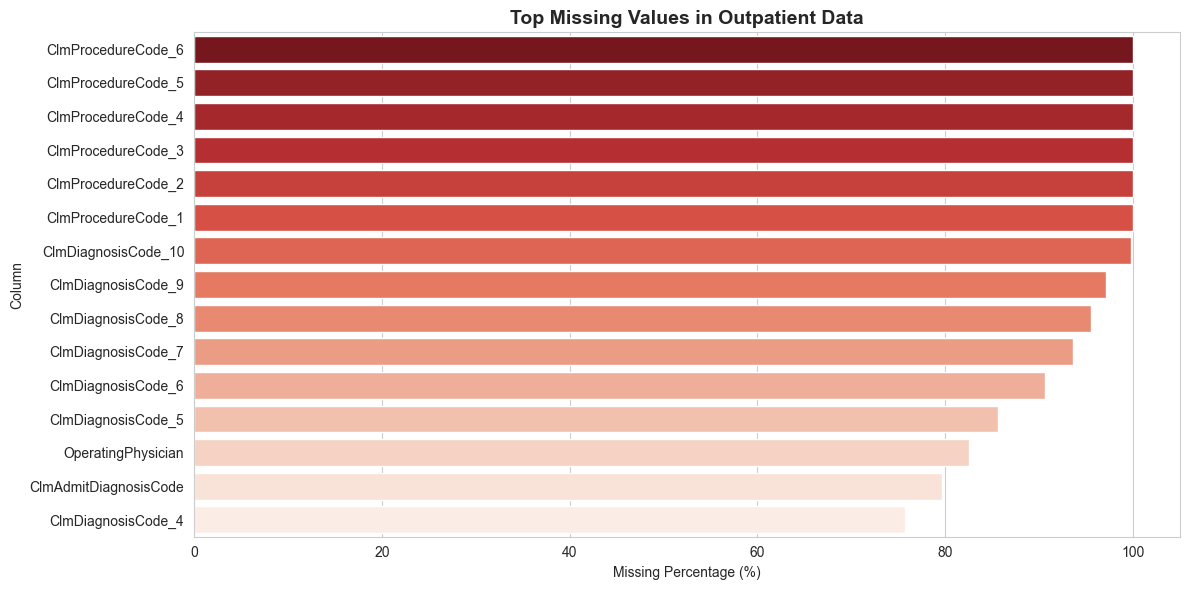


✓ No missing values in Labels Data


In [4]:
def analyze_missing(df, name):
    """Analyze and visualize missing values"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Missing_Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n{'='*60}")
        print(f"Missing Values in {name}")
        print(f"{'='*60}")
        print(missing_df.to_string(index=False))
        
        # Plot top 15 columns with missing values
        if len(missing_df) > 0:
            plt.figure(figsize=(12, 6))
            top_missing = missing_df.head(15)
            sns.barplot(data=top_missing, y='Column', x='Missing_Percentage', palette='Reds_r')
            plt.title(f'Top Missing Values in {name}', fontsize=14, fontweight='bold')
            plt.xlabel('Missing Percentage (%)')
            plt.tight_layout()
            plt.show()
    else:
        print(f"\n✓ No missing values in {name}")

# Analyze each dataset
analyze_missing(train_bene, "Beneficiary Data")
analyze_missing(train_inpatient, "Inpatient Data")
analyze_missing(train_outpatient, "Outpatient Data")
analyze_missing(train_labels, "Labels Data")

**Observations**:
- Diagnosis and procedure codes have high missingness (expected - not all claims use all code fields)
- Physician fields have some missingness
- `DeductibleAmtPaid` has missing values (likely when fully covered by insurance)

### 3.3 Data Preprocessing

In [5]:
# Convert date columns
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']

for col in date_cols:
    if col in train_inpatient.columns:
        train_inpatient[col] = pd.to_datetime(train_inpatient[col], errors='coerce')
    if col in train_outpatient.columns:
        train_outpatient[col] = pd.to_datetime(train_outpatient[col], errors='coerce')

train_bene['DOB'] = pd.to_datetime(train_bene['DOB'], errors='coerce')
train_bene['DOD'] = pd.to_datetime(train_bene['DOD'], errors='coerce')

# Calculate claim duration
train_inpatient['ClaimDuration'] = (train_inpatient['ClaimEndDt'] - train_inpatient['ClaimStartDt']).dt.days + 1
train_outpatient['ClaimDuration'] = (train_outpatient['ClaimEndDt'] - train_outpatient['ClaimStartDt']).dt.days + 1

# Calculate length of stay for inpatient
if 'AdmissionDt' in train_inpatient.columns and 'DischargeDt' in train_inpatient.columns:
    train_inpatient['LengthOfStay'] = (train_inpatient['DischargeDt'] - train_inpatient['AdmissionDt']).dt.days + 1

# Calculate age (approximate at 2009)
train_bene['Age'] = 2009 - train_bene['DOB'].dt.year

print("✓ Date preprocessing completed")
print(f"Inpatient claim duration range: {train_inpatient['ClaimDuration'].min()} to {train_inpatient['ClaimDuration'].max()} days")
print(f"Outpatient claim duration range: {train_outpatient['ClaimDuration'].min()} to {train_outpatient['ClaimDuration'].max()} days")

✓ Date preprocessing completed
Inpatient claim duration range: 1 to 37 days
Outpatient claim duration range: 1 to 24 days


### 3.4 Merge Data for Analysis

In [6]:
# Merge beneficiary info into claims
inpatient_full = pd.merge(train_inpatient, train_bene, on='BeneID', how='left')
outpatient_full = pd.merge(train_outpatient, train_bene, on='BeneID', how='left')

# Merge labels for EDA
inpatient_eda = pd.merge(inpatient_full, train_labels, on='Provider', how='left')
outpatient_eda = pd.merge(outpatient_full, train_labels, on='Provider', how='left')

print(f"Inpatient (with beneficiary & labels): {inpatient_eda.shape}")
print(f"Outpatient (with beneficiary & labels): {outpatient_eda.shape}")

Inpatient (with beneficiary & labels): (40474, 58)
Outpatient (with beneficiary & labels): (517737, 54)


### 3.5 Financial Features Analysis

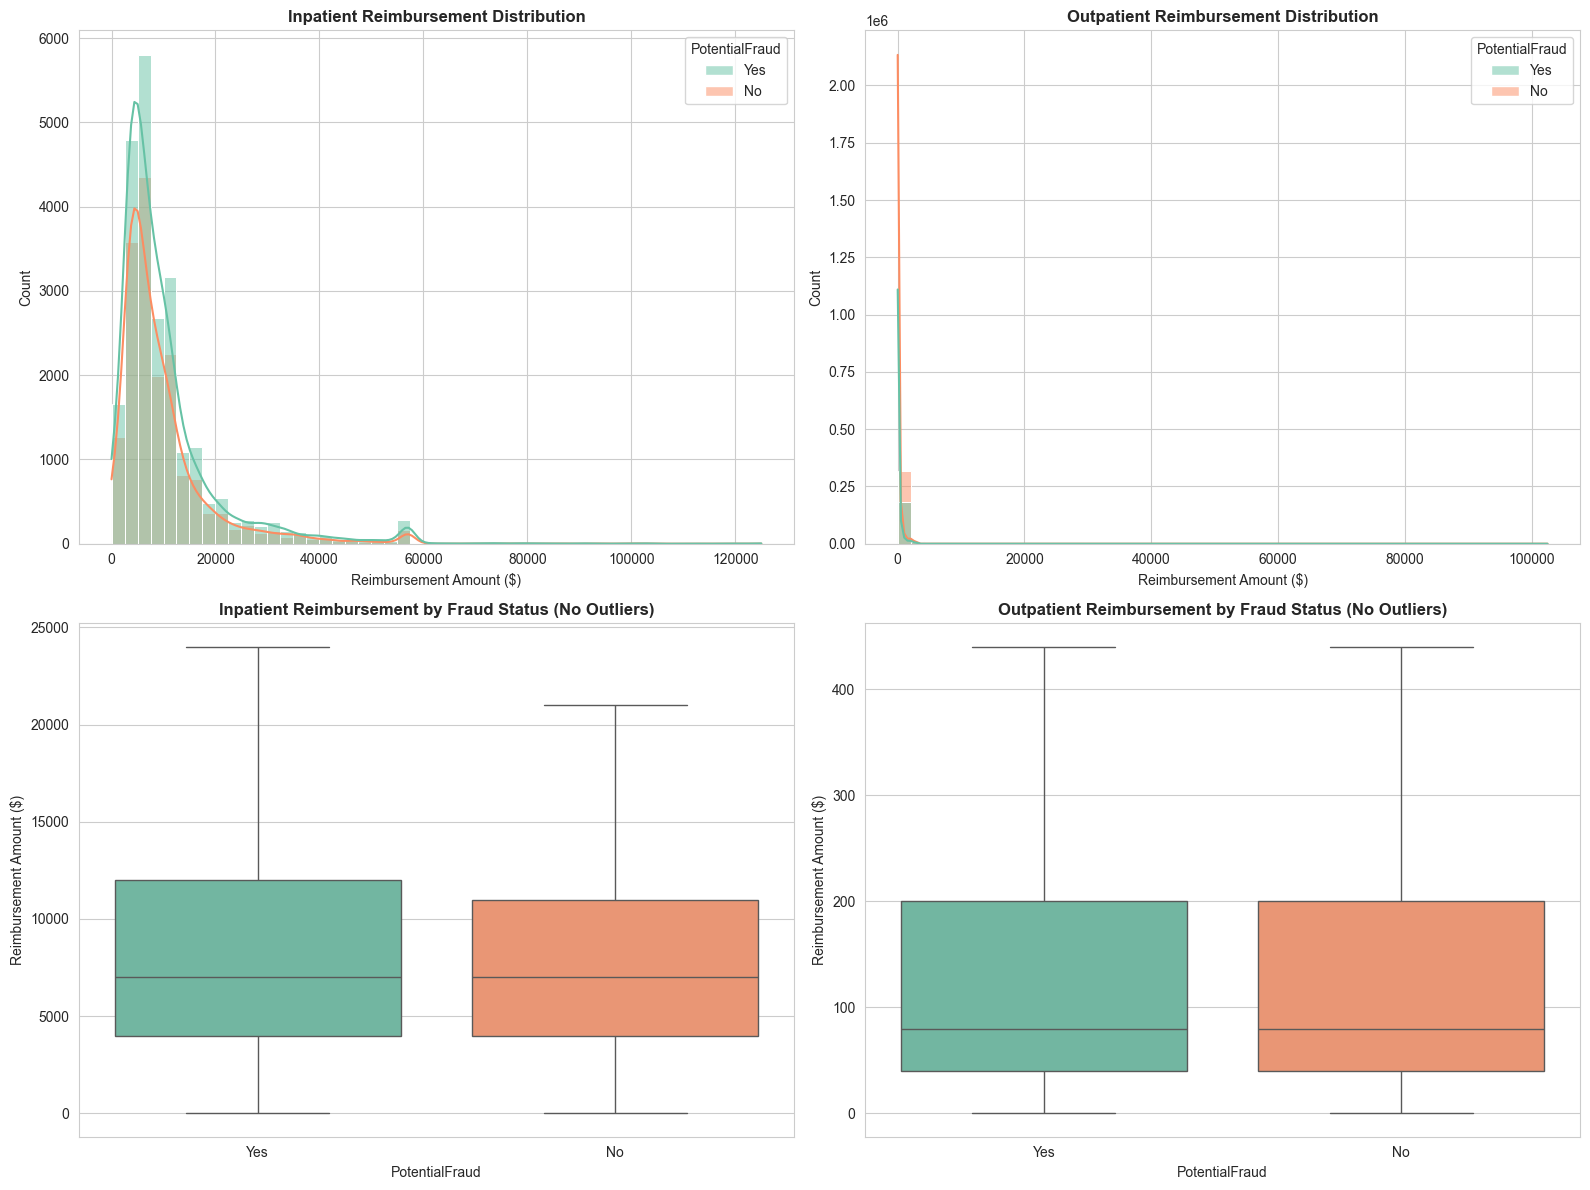

In [7]:
# Claim amount distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Inpatient reimbursement distribution
sns.histplot(data=inpatient_eda, x='InscClaimAmtReimbursed', hue='PotentialFraud', 
             kde=True, bins=50, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Inpatient Reimbursement Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Reimbursement Amount ($)')

# Outpatient reimbursement distribution
sns.histplot(data=outpatient_eda, x='InscClaimAmtReimbursed', hue='PotentialFraud',
             kde=True, bins=50, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Outpatient Reimbursement Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Reimbursement Amount ($)')

# Inpatient reimbursement by fraud (log scale)
sns.boxplot(data=inpatient_eda, x='PotentialFraud', y='InscClaimAmtReimbursed', 
            ax=axes[1, 0], palette='Set2', showfliers=False)
axes[1, 0].set_title('Inpatient Reimbursement by Fraud Status (No Outliers)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Reimbursement Amount ($)')

# Outpatient reimbursement by fraud
sns.boxplot(data=outpatient_eda, x='PotentialFraud', y='InscClaimAmtReimbursed',
            ax=axes[1, 1], palette='Set2', showfliers=False)
axes[1, 1].set_title('Outpatient Reimbursement by Fraud Status (No Outliers)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Reimbursement Amount ($)')

plt.tight_layout()
plt.show()

### 3.6 Claim Duration Analysis

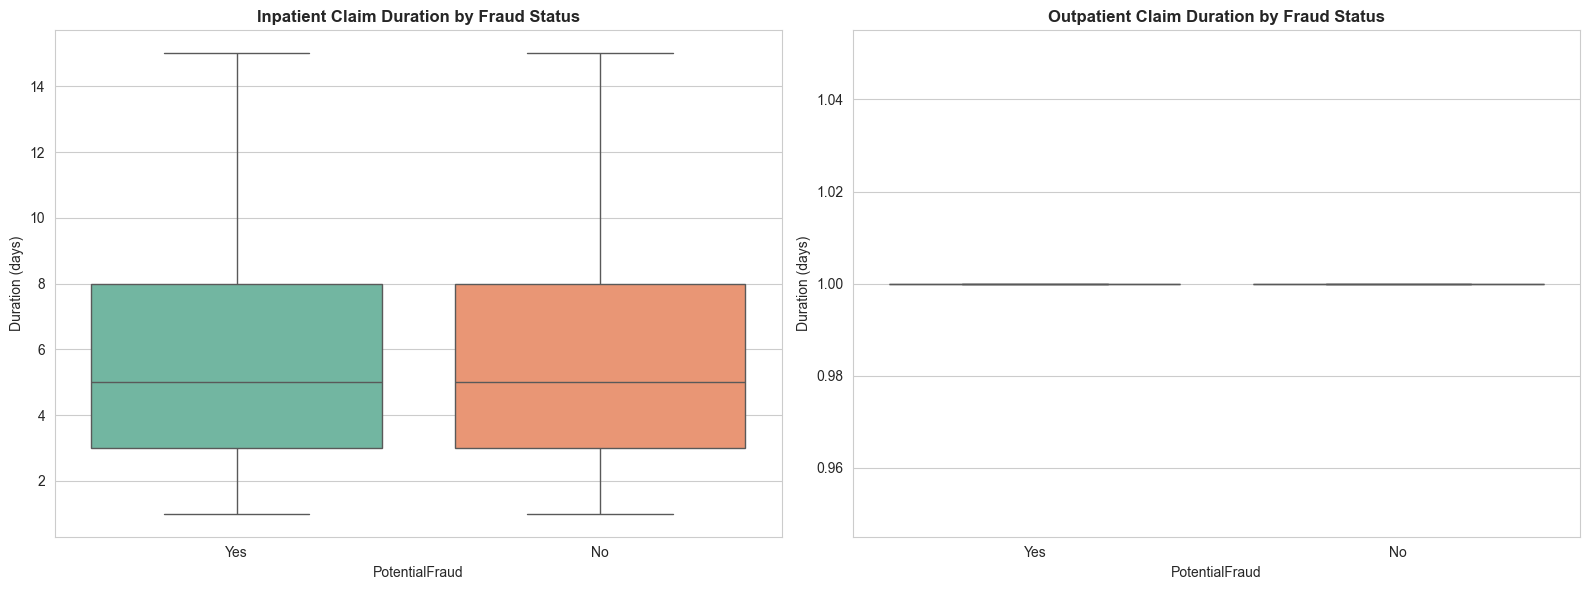


Claim Duration Statistics:

Inpatient:
                  count      mean       std  min  25%  50%  75%   max
PotentialFraud                                                       
No              17072.0  6.553831  5.329792  1.0  3.0  5.0  8.0  36.0
Yes             23402.0  6.737886  5.836285  1.0  3.0  5.0  8.0  37.0

Outpatient:
                   count      mean       std  min  25%  50%  75%   max
PotentialFraud                                                        
No              328343.0  2.413022  4.695344  1.0  1.0  1.0  1.0  22.0
Yes             189394.0  2.433551  4.728177  1.0  1.0  1.0  1.0  24.0


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Inpatient claim duration
sns.boxplot(data=inpatient_eda, x='PotentialFraud', y='ClaimDuration',
            ax=axes[0], palette='Set2', showfliers=False)
axes[0].set_title('Inpatient Claim Duration by Fraud Status', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Duration (days)')

# Outpatient claim duration
sns.boxplot(data=outpatient_eda, x='PotentialFraud', y='ClaimDuration',
            ax=axes[1], palette='Set2', showfliers=False)
axes[1].set_title('Outpatient Claim Duration by Fraud Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Duration (days)')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nClaim Duration Statistics:")
print("\nInpatient:")
print(inpatient_eda.groupby('PotentialFraud')['ClaimDuration'].describe())
print("\nOutpatient:")
print(outpatient_eda.groupby('PotentialFraud')['ClaimDuration'].describe())

### 3.7 Outlier Detection

In [9]:
# Identify outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), (len(outliers) / len(df)) * 100

print("Outlier Analysis:")
print("\nInpatient Reimbursement:")
count, pct = detect_outliers(inpatient_eda, 'InscClaimAmtReimbursed')
print(f"  Outliers: {count} ({pct:.2f}%)")

print("\nOutpatient Reimbursement:")
count, pct = detect_outliers(outpatient_eda, 'InscClaimAmtReimbursed')
print(f"  Outliers: {count} ({pct:.2f}%)")

print("\n⚠️ High outlier percentage suggests diverse provider types and potential fraud patterns")

Outlier Analysis:

Inpatient Reimbursement:
  Outliers: 2966 (7.33%)

Outpatient Reimbursement:
  Outliers: 78375 (15.14%)

⚠️ High outlier percentage suggests diverse provider types and potential fraud patterns


## 4. Feature Engineering: Provider-Level Aggregation

### Strategy
We aggregate claim-level and beneficiary-level data to create comprehensive provider profiles:

1. **Financial Features**: Total/average reimbursements, deductibles
2. **Volume Features**: Claim counts, beneficiary counts, claim ratios
3. **Medical Complexity**: Diagnosis/procedure counts, chronic conditions
4. **Temporal Features**: Average claim durations, length of stay
5. **Demographic Features**: Average patient age

In [10]:
def engineer_provider_features(claims_df, prefix):
    """
    Aggregate claim-level data to provider level
    
    Parameters:
    - claims_df: DataFrame with claims and merged beneficiary data
    - prefix: 'Inpatient' or 'Outpatient'
    
    Returns:
    - DataFrame with provider-level features
    """
    
    # Chronic condition columns (convert 2=No to 0, keep 1=Yes)
    chronic_cols = [col for col in claims_df.columns if 'ChronicCond' in col]
    for col in chronic_cols:
        claims_df[col] = claims_df[col].replace(2, 0)
    
    # Count diagnosis and procedure codes
    diag_cols = [col for col in claims_df.columns if 'ClmDiagnosisCode' in col]
    proc_cols = [col for col in claims_df.columns if 'ClmProcedureCode' in col]
    
    claims_df['NumDiagnoses'] = claims_df[diag_cols].notnull().sum(axis=1)
    claims_df['NumProcedures'] = claims_df[proc_cols].notnull().sum(axis=1)
    
    # Aggregation functions
    agg_dict = {
        # Volume
        'ClaimID': 'count',
        'BeneID': 'nunique',
        
        # Financial
        'InscClaimAmtReimbursed': ['sum', 'mean', 'std', 'max'],
        'DeductibleAmtPaid': ['sum', 'mean'],
        
        # Temporal
        'ClaimDuration': ['mean', 'max'],
        
        # Demographics
        'Age': 'mean',
        
        # Medical complexity
        'NumDiagnoses': ['mean', 'max'],
        'NumProcedures': ['mean', 'max'],
        
        # Physicians
        'AttendingPhysician': 'nunique',
        'OperatingPhysician': 'nunique',
        'OtherPhysician': 'nunique'
    }
    
    # Add length of stay for inpatient
    if 'LengthOfStay' in claims_df.columns:
        agg_dict['LengthOfStay'] = ['mean', 'max']
    
    # Add chronic conditions (mean = percentage of patients with condition)
    for col in chronic_cols:
        agg_dict[col] = 'mean'
    
    # Group by provider
    provider_features = claims_df.groupby('Provider').agg(agg_dict)
    
    # Flatten column names
    provider_features.columns = [
        f"{prefix}_{col[0]}_{col[1]}" if isinstance(col, tuple) else f"{prefix}_{col}"
        for col in provider_features.columns
    ]
    
    return provider_features

print("Aggregating Inpatient features...")
inpatient_features = engineer_provider_features(inpatient_full, 'Inpatient')
print(f"  Shape: {inpatient_features.shape}")

print("\nAggregating Outpatient features...")
outpatient_features = engineer_provider_features(outpatient_full, 'Outpatient')
print(f"  Shape: {outpatient_features.shape}")

Aggregating Inpatient features...
  Shape: (2092, 31)

Aggregating Outpatient features...
  Shape: (5012, 29)


### 4.1 Combine Features and Create Derived Metrics

In [11]:
# Merge inpatient and outpatient features
provider_df = pd.merge(inpatient_features, outpatient_features, 
                       on='Provider', how='outer')

# Fill NaN with 0 (providers with only inpatient or only outpatient)
provider_df = provider_df.fillna(0)

print(f"Combined provider features shape: {provider_df.shape}")

# Create derived features
print("\nCreating derived features...")

# Total claims
provider_df['Total_Claims'] = (provider_df['Inpatient_ClaimID_count'] + 
                                provider_df['Outpatient_ClaimID_count'])

# Total reimbursement
provider_df['Total_Reimbursement'] = (provider_df['Inpatient_InscClaimAmtReimbursed_sum'] +
                                       provider_df['Outpatient_InscClaimAmtReimbursed_sum'])

# Average reimbursement per claim
provider_df['Avg_Reimbursement_Per_Claim'] = provider_df['Total_Reimbursement'] / (provider_df['Total_Claims'] + 1e-5)

# Inpatient to outpatient ratio
provider_df['Inpatient_Outpatient_Ratio'] = (provider_df['Inpatient_ClaimID_count'] / 
                                              (provider_df['Outpatient_ClaimID_count'] + 1))

# Total unique beneficiaries
provider_df['Total_Unique_Beneficiaries'] = (provider_df['Inpatient_BeneID_nunique'] +
                                              provider_df['Outpatient_BeneID_nunique'])

# Claims per beneficiary
provider_df['Claims_Per_Beneficiary'] = provider_df['Total_Claims'] / (provider_df['Total_Unique_Beneficiaries'] + 1e-5)

# Average chronic conditions (sum of percentages)
chronic_in_cols = [c for c in provider_df.columns if 'ChronicCond' in c and 'Inpatient' in c]
chronic_out_cols = [c for c in provider_df.columns if 'ChronicCond' in c and 'Outpatient' in c]

if chronic_in_cols:
    provider_df['Avg_Chronic_Conditions_Inpatient'] = provider_df[chronic_in_cols].sum(axis=1)
if chronic_out_cols:
    provider_df['Avg_Chronic_Conditions_Outpatient'] = provider_df[chronic_out_cols].sum(axis=1)

print(f"\n✓ Feature engineering complete. Total features: {provider_df.shape[1]}")

Combined provider features shape: (5410, 60)

Creating derived features...

✓ Feature engineering complete. Total features: 68


### 4.2 Merge with Labels

In [12]:
# Merge with fraud labels
provider_df_final = pd.merge(provider_df, train_labels, on='Provider', how='inner')

# Encode target variable
provider_df_final['PotentialFraud'] = provider_df_final['PotentialFraud'].map({'Yes': 1, 'No': 0})

print(f"Final dataset shape: {provider_df_final.shape}")
print(f"\nTarget distribution:")
print(provider_df_final['PotentialFraud'].value_counts())

provider_df_final.head()

Final dataset shape: (5410, 70)

Target distribution:
PotentialFraud
0    4904
1     506
Name: count, dtype: int64


,Provider,Inpatient_ClaimID_count,Inpatient_BeneID_nunique,Inpatient_InscClaimAmtReimbursed_sum,Inpatient_InscClaimAmtReimbursed_mean,Inpatient_InscClaimAmtReimbursed_std,Inpatient_InscClaimAmtReimbursed_max,Inpatient_DeductibleAmtPaid_sum,Inpatient_DeductibleAmtPaid_mean,Inpatient_ClaimDuration_mean,...,Outpatient_ChronicCond_stroke_mean,Total_Claims,Total_Reimbursement,Avg_Reimbursement_Per_Claim,Inpatient_Outpatient_Ratio,Total_Unique_Beneficiaries,Claims_Per_Beneficiary,Avg_Chronic_Conditions_Inpatient,Avg_Chronic_Conditions_Outpatient,PotentialFraud
0,PRV51001,5.0,5.0,97000.0,19400.000000,18352.111595,42000.0,5340.0,1068.0,6.000000,...,0.200000,25.0,104640.0,4185.598326,0.238095,24.0,1.041666,6.000000,5.450000,0
1,PRV51003,62.0,53.0,573000.0,9241.935484,8513.606244,57000.0,66216.0,1068.0,6.161290,...,0.071429,132.0,605670.0,4588.408743,0.873239,119.0,1.109244,4.919355,4.214286,1
2,PRV51004,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.114094,149.0,52170.0,350.134205,0.000000,138.0,1.079710,0.000000,4.342282,0
3,PRV51005,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.106438,1165.0,280910.0,241.124461,0.000000,495.0,2.353535,0.000000,4.335622,1
4,PRV51007,3.0,3.0,19000.0,6333.333333,3511.884584,10000.0,3204.0,1068.0,6.333333,...,0.144928,72.0,33710.0,468.194379,0.042857,59.0,1.220339,5.666667,4.101449,0


### 4.3 Provider-Level Descriptive Statistics

In [13]:
# Key statistics by fraud status
key_features = ['Total_Claims', 'Total_Reimbursement', 'Total_Unique_Beneficiaries',
                'Avg_Reimbursement_Per_Claim', 'Inpatient_Outpatient_Ratio']

print("Provider-Level Statistics by Fraud Status:")
print("="*80)
for feature in key_features:
    print(f"\n{feature}:")
    print(provider_df_final.groupby('PotentialFraud')[feature].describe())

Provider-Level Statistics by Fraud Status:

Total_Claims:
                 count        mean         std  min   25%    50%    75%  \
PotentialFraud                                                            
0               4904.0   70.435359  128.942510  1.0   9.0   27.0   72.0   
1                506.0  420.545455  722.734485  1.0  62.0  155.5  432.0   

                   max  
PotentialFraud          
0               1245.0  
1               8240.0  

Total_Reimbursement:
                 count           mean            std    min       25%  \
PotentialFraud                                                          
0               4904.0   53193.723491  102342.349409    0.0    3797.5   
1                506.0  584350.039526  644668.507561  200.0  172947.5   

                     50%       75%        max  
PotentialFraud                                 
0                15055.0   57422.5  1311040.0  
1               373450.0  759740.0  5996050.0  

Total_Unique_Beneficiaries:
     

### 4.4 Correlation Analysis

Top 15 Features Correlated with Fraud:
PotentialFraud                          1.000000
Total_Reimbursement                     0.575558
Inpatient_ClaimDuration_max             0.542879
Inpatient_LengthOfStay_max              0.542662
Inpatient_InscClaimAmtReimbursed_sum    0.532795
Inpatient_DeductibleAmtPaid_sum         0.525454
Inpatient_ClaimID_count                 0.525393
Inpatient_BeneID_nunique                0.522256
Inpatient_InscClaimAmtReimbursed_max    0.504854
Inpatient_NumProcedures_max             0.444011
Total_Unique_Beneficiaries              0.399033
Total_Claims                            0.374197
Inpatient_InscClaimAmtReimbursed_std    0.364039
Inpatient_NumDiagnoses_max              0.342265
Outpatient_BeneID_nunique               0.340550
Name: PotentialFraud, dtype: float64


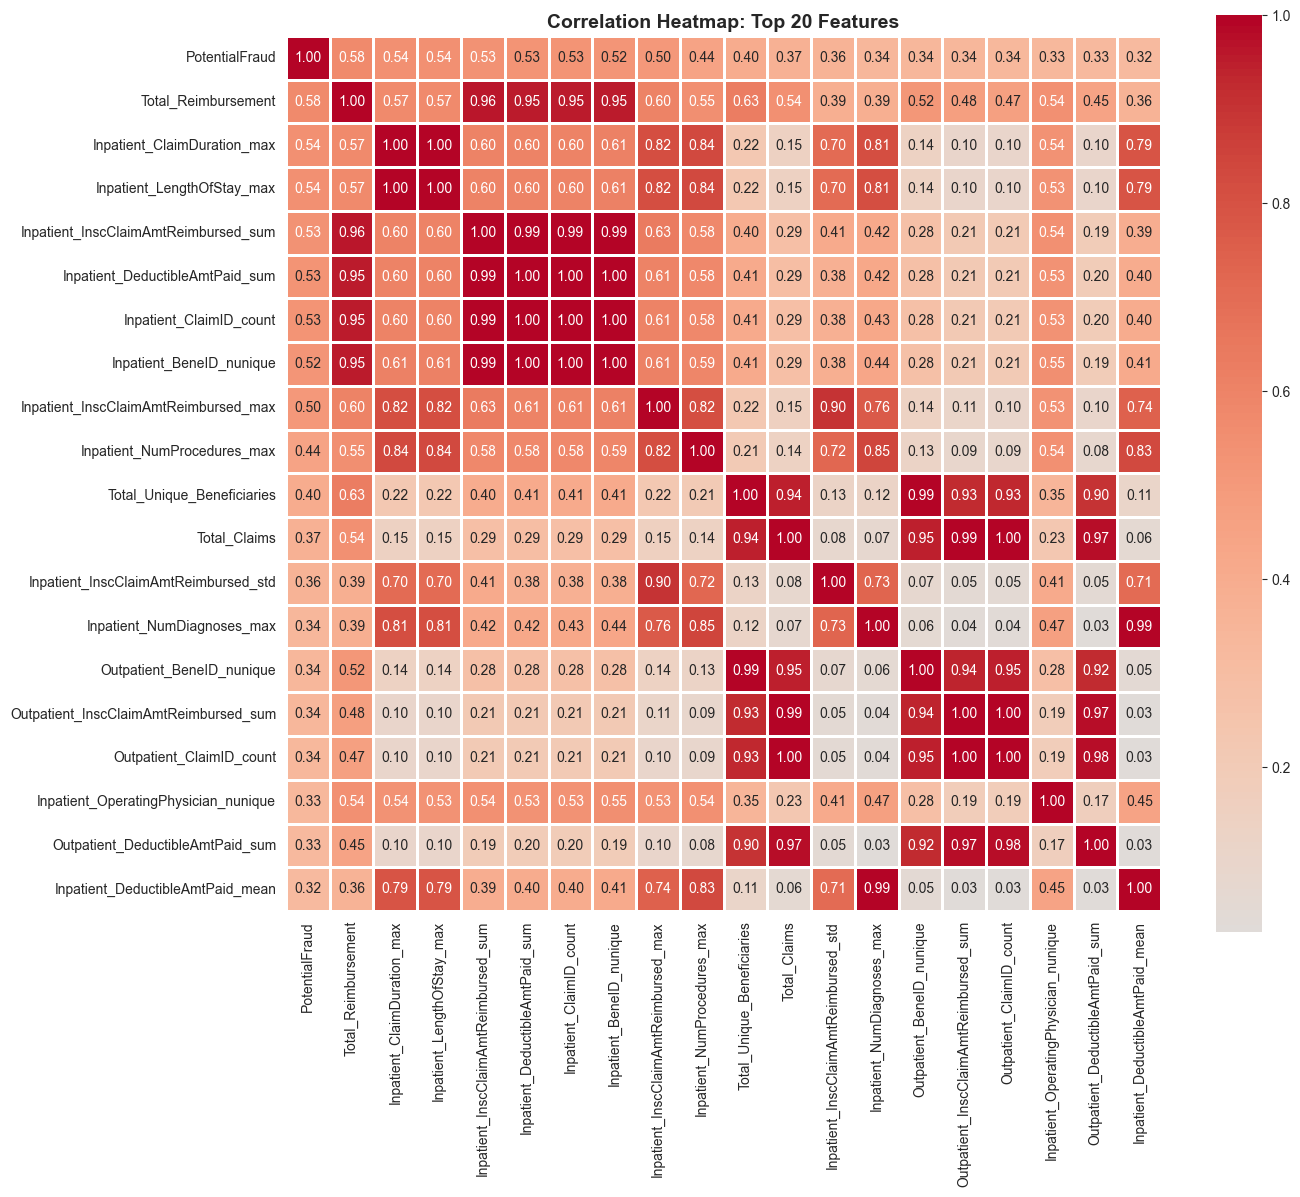

In [14]:
# Select numeric columns for correlation
numeric_cols = provider_df_final.select_dtypes(include=[np.number]).columns.tolist()

# Correlation with target
correlations = provider_df_final[numeric_cols].corr()['PotentialFraud'].sort_values(ascending=False)
print("Top 15 Features Correlated with Fraud:")
print(correlations.head(15))

# Correlation heatmap (top features)
top_features = correlations.abs().sort_values(ascending=False).head(20).index.tolist()
plt.figure(figsize=(14, 12))
sns.heatmap(provider_df_final[top_features].corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap: Top 20 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Save Final Dataset

In [15]:
# Save to CSV
output_path = DATA_DIR + 'provider_features.csv'
provider_df_final.to_csv(output_path, index=False)

print(f"✓ Final dataset saved to: {output_path}")
print(f"  Shape: {provider_df_final.shape}")
print(f"  Features: {provider_df_final.shape[1] - 2}") 
print(f"  Providers: {provider_df_final.shape[0]}")
print(f"  Fraud cases: {provider_df_final['PotentialFraud'].sum()}")

✓ Final dataset saved to: ../data/provider_features.csv
  Shape: (5410, 70)
  Features: 68
  Providers: 5410
  Fraud cases: 506


## Summary

### Key Findings from EDA:
1. **Class Imbalance**: ~10% fraud rate requires special handling
2. **Missing Data**: High missingness in diagnosis/procedure codes (expected)
3. **Financial Patterns**: Fraudulent providers show different reimbursement distributions
4. **Outliers**: Significant outliers in financial features suggest diverse fraud patterns

### Feature Engineering Accomplishments:
- Created **comprehensive provider-level features** from claim and beneficiary data
- Engineered **financial, volume, medical complexity, and temporal features**
- Generated **derived metrics** (ratios, averages, totals)
- Final dataset ready for modeling

### Next Steps:
→ Proceed to **Notebook 02: Modeling**